In [14]:
# Veriyi okuma ve işleme için kütüphaneler
import cv2 as cv
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen


In [15]:
# Warningleri kapamak için kütüphaneler
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Model değerlendirme için kullanılacak kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# Model için kullanılacak kütüphaneler
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D,Flatten,MaxPool2D,Dense,Dropout,SpatialDropout2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [55]:

# Veri seti okunması

path_data = os.path.dirname(r"D:\Derin Ogrenme\CNN\Garbage_Data\Garbage classification")
target_size = (224,224)
# burdaki işlem kritik bir işlem path içindeki her dosya adını encode etmemize sağlayacak sözlük yapısı
waste_labels = {'cardboard':0,'glass':1,'metal':2,'paper':3,'plastic':4,'trash':5}

def load_datasets(path):
    """ path: görsellerin bulunduğu dizini ifade eder.
        return:
        x: görüntülere ait matris bilgilerini tutar
        labels: görüntünün ait olduğu sinif bilgisini tutar."""
    x = []
    labels = []

    # Gönderdiğimiz path içindeki görüntüleri listeleyip sıralamaktadır.
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        # Belirtilen pathdeki görüntüler openCV ile okunmaktadır.
        img = cv.imread(image_path)

        # Görüntüleri başlangıç durumundan farklı olarak resize göre yeniden ölçeklendirme
        # Başlangıç 512x384  Resize 224x224
        img = cv.resize(img,target_size)

        # x listesine ekleme
        x.append(img)

        # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labeldır.
        label = image_path.split(os.path.sep)[-2]
        

        # Yakalanan labeller daha önceki dict göre sayısal değerlere karşılık gelen key olarak listeye ekleniyor.
        labels.append(waste_labels[label])

    # Veri setinini random bir şekilde karıştır.
    x,labels = shuffle(x,labels,random_state=42)

    # Boyut ve sınıf bilgisi raporlanmaktadır.
    print(f'X boyutu : {np.array(x).shape}')
    print(f'Label sinif sayisi: {len(np.unique(labels))} Gözlem sayisi: {len(labels)}')

    return x, labels
    
x,labels = load_datasets(path=path_data)

X boyutu : (2527, 224, 224, 3)
Label sinif sayisi: 6 Gözlem sayisi: 2527


In [59]:
def visualize_img(image_batch, label_batch):
    """image_batch: görüntülere ait matris bilgilerini tutar.
       label_batch: görüntünün ait olduğu sinif bilgisini tutan liste"""
    
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
        plt.axis('off')

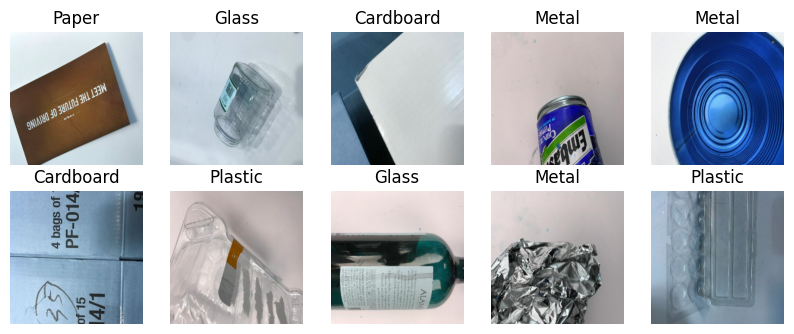

In [60]:
visualize_img(x,labels)

In [61]:
# Veriyi hazırlama

train = ImageDataGenerator(horizontal_flip=True, #görevi veri üretmektir. veri çeşitlendirmeyi sağlar.
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range= 0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

#width_shift_range ve height_shift_range argümanları ile görüntü kaydırma
#horizontal_flip ve vertical_flip argümanları ile görüntü çevirme
#zoom_range argümanı ile görüntü yakınlaştırma
#rotation_range argümanı ile rastgele görüntü çevirme
#brightness_range argümanı ile parlaklık ayarı
#shear_range argümanı görüntünün şekline eğim vermek için kullanılır.

test = ImageDataGenerator(rescale=1/255,validation_split=0.1)

In [63]:
train_generator = train.flow_from_directory(directory=path_data,
                                           target_size=(target_size),
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           subset='training')

test_generator = test.flow_from_directory(directory=path_data,
                                           target_size=(target_size),
                                           batch_size=25,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           subset='validation')

# Veriyi bu yapıları sayesinde hazırlıyoruz
# Eğer class mode da sınıfımız iki adet ise binary kullanmamız gerek
# ve alt kümelerde yaşanacak işlemler için training ve validation olduğunu belirlemeliyiz

Found 2275 images belonging to 1 classes.
Found 252 images belonging to 1 classes.
